In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#from ydata_profiling import ProfileReport

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,make_scorer,r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [2]:
import random
np.random.seed(42)
random.seed(42)

In [3]:
df_diamonds = pd.read_csv("diamonds.csv")

In [4]:
df_diamond = df_diamonds.drop(columns = "Unnamed: 0")

In [5]:
train_set, test_set = train_test_split(df_diamond, test_size = 0.2)

In [6]:
train_features = train_set.drop(columns = "price")
train_labels = pd.DataFrame(train_set["price"])

test_features = test_set.drop(columns = "price")
test_labels = pd.DataFrame(test_set["price"])


In [7]:
#Pipeline only cat
num_attributes = ["carat","depth","table","x","y","z"]
cat_cut_level = [['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']] 
cat_color_level = [['J', 'I', 'H', 'G', 'F', 'E', 'D']]
cat_clarity_level = [['I1', 'SI2', 'SI1', 'VS2','VS1', 'VVS2','VVS1', 'IF']]
cat_attributes= ["cut","color","clarity"]

full_pipeline_cat = ColumnTransformer(
    transformers = [
    ("cat_cut",     OrdinalEncoder(categories=cat_cut_level),["cut"]),
    ("cat_color",   OrdinalEncoder(categories=cat_color_level),["color"]),
    ("cat_clarity", OrdinalEncoder(categories=cat_clarity_level),["clarity"])
    ],
    remainder = "passthrough"
)
    
train_features_cat = full_pipeline_cat.fit_transform(train_features)
test_features_cat = full_pipeline_cat.transform(test_features)

if(full_pipeline_cat.sparse_output_):
    train_features_cat = train_features_cat.toarray()
    test_features_cat = test_features_cat.toarray()
    
#Make them dataframe
df_train_features_cat = pd.DataFrame(train_features_cat, columns =  cat_attributes + num_attributes )
df_test_features_cat = pd.DataFrame(test_features_cat, columns = cat_attributes + num_attributes )

In [8]:
#Pipeline with standardscaler
num_attributes = ["carat","depth","table","x","y","z"]
all_atributes =  cat_attributes + num_attributes

num_pipeline_scaler = Pipeline([
    ('std_scaler',StandardScaler()),
])


full_pipeline_scaler = ColumnTransformer(
    transformers = [
    ("num", num_pipeline_scaler, all_atributes),
    ],
    remainder = "passthrough"
)
    

train_features_ss = full_pipeline_scaler.fit_transform(df_train_features_cat)
test_features_ss = full_pipeline_scaler.transform(df_test_features_cat)

if(full_pipeline_scaler.sparse_output_):
    train_features_ss = train_features_ss.toarray()
    test_features_ss = test_features_ss.toarray()
    
#Make them dataframe
df_train_features_ss = pd.DataFrame(train_features_ss, columns = all_atributes)
df_test_features_ss  = pd.DataFrame(test_features_ss, columns = all_atributes)

In [9]:
label_process_ss = StandardScaler()
train_labels_ss = label_process_ss.fit_transform(train_labels)
test_labels_ss = label_process_ss.transform(test_labels)
   
#Make them dataframe
df_train_labels_ss = pd.DataFrame(train_labels_ss, columns = ["price"])
df_test_labels_ss  = pd.DataFrame(test_labels_ss, columns = ["price"])

In [10]:
#Random Forest Part

In [11]:
"""
RandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                      max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, 
                      oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, 
                      ccp_alpha=0.0, max_samples=None)
"""

"\nRandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, \n                      min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, \n                      max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, \n                      oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, \n                      ccp_alpha=0.0, max_samples=None)\n"

In [12]:
from sklearn.ensemble import RandomForestRegressor
default_pipeline = Pipeline([
    ('model',RandomForestRegressor(oob_score = True))
    ])


params = [
     {
          "model":[RandomForestRegressor()],
          "model__max_depth":[2,3,4,5,6,7,8,9,10,15,25,50,100,250],
          "model__n_estimators":[1,5,10,100],
          "model__max_features":[1,2,3,4,5,6,7,8,9]
     }
]

In [13]:
array_train = np.array(df_train_features_ss)
array_label = np.array(df_train_labels_ss).ravel()

g_s = GridSearchCV(default_pipeline, params,cv=KFold(n_splits=10,shuffle = True, random_state = 42),n_jobs=-1, scoring=('neg_root_mean_squared_error'),verbose=10,
                    return_train_score=False)
g_s.fit(array_train,array_label)

Fitting 10 folds for each of 504 candidates, totalling 5040 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('model',
                                        RandomForestRegressor(oob_score=True))]),
             n_jobs=-1,
             param_grid=[{'model': [RandomForestRegressor(max_depth=15,
                                                          max_features=6)],
                          'model__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15,
                                               25, 50, 100, 250],
                          'model__max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                          'model__n_estimators': [1, 5, 10, 100]}],
             scoring='neg_root_mean_squared_error', verbose=10)

In [14]:
import joblib
joblib.dump(g_s, 'rf_grid_search.pkl')

['rf_grid_search.pkl']

In [15]:
import joblib
grid_search = joblib.load('rf_grid_search.pkl')

In [16]:
df_g = pd.DataFrame(grid_search.cv_results_)
sorted_g = df_g.sort_values(by='rank_test_score', ascending=True)

In [17]:
sorted_g[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__max_depth,param_model__max_features,param_model__n_estimators,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
347,16.930502,0.509457,0.212502,0.026401,"RandomForestRegressor(max_depth=15, max_featur...",15,6,100,"{'model': RandomForestRegressor(max_depth=15, ...",-0.137512,...,-0.134900,-0.137503,-0.137621,-0.133735,-0.133241,-0.139271,-0.132043,-0.135473,0.002439,1
387,21.003320,0.238296,0.256313,0.013921,"RandomForestRegressor(max_depth=15, max_featur...",25,7,100,"{'model': RandomForestRegressor(max_depth=15, ...",-0.136915,...,-0.134298,-0.136257,-0.139320,-0.132232,-0.135768,-0.138705,-0.133576,-0.135586,0.002358,2
491,18.907189,0.352489,0.260261,0.016607,"RandomForestRegressor(max_depth=15, max_featur...",250,6,100,"{'model': RandomForestRegressor(max_depth=15, ...",-0.138931,...,-0.133927,-0.136853,-0.137644,-0.133345,-0.134869,-0.139811,-0.132856,-0.135713,0.002536,3
495,21.304582,0.268132,0.254560,0.010310,"RandomForestRegressor(max_depth=15, max_featur...",250,7,100,"{'model': RandomForestRegressor(max_depth=15, ...",-0.137054,...,-0.135853,-0.137658,-0.138925,-0.132857,-0.135103,-0.137221,-0.134099,-0.135732,0.002028,4
455,26.267075,1.053265,0.378955,0.033078,"RandomForestRegressor(max_depth=15, max_featur...",100,6,100,"{'model': RandomForestRegressor(max_depth=15, ...",-0.137698,...,-0.134278,-0.136657,-0.138924,-0.133392,-0.135262,-0.139419,-0.132465,-0.135767,0.002432,5
343,13.992355,0.500458,0.206782,0.028562,"RandomForestRegressor(max_depth=15, max_featur...",15,5,100,"{'model': RandomForestRegressor(max_depth=15, ...",-0.137760,...,-0.133336,-0.138711,-0.139368,-0.132527,-0.133295,-0.141469,-0.133179,-0.135810,0.003160,6
379,15.499329,0.287799,0.265655,0.015596,"RandomForestRegressor(max_depth=15, max_featur...",25,5,100,"{'model': RandomForestRegressor(max_depth=15, ...",-0.137837,...,-0.134685,-0.136096,-0.139330,-0.133594,-0.135090,-0.141034,-0.131942,-0.135822,0.002879,7
351,19.735656,0.685070,0.205301,0.022719,"RandomForestRegressor(max_depth=15, max_featur...",15,7,100,"{'model': RandomForestRegressor(max_depth=15, ...",-0.137145,...,-0.135950,-0.137247,-0.138192,-0.132963,-0.134702,-0.140756,-0.133472,-0.135890,0.002478,8
419,18.654549,0.364235,0.247684,0.017661,"RandomForestRegressor(max_depth=15, max_featur...",50,6,100,"{'model': RandomForestRegressor(max_depth=15, ...",-0.137416,...,-0.134925,-0.136666,-0.139171,-0.133327,-0.135647,-0.140986,-0.133041,-0.135909,0.002708,9
423,21.099040,0.455275,0.260547,0.018787,"RandomForestRegressor(max_depth=15, max_featur...",50,7,100,"{'model': RandomForestRegressor(max_depth=15, ...",-0.137466,...,-0.135040,-0.136867,-0.137748,-0.133201,-0.135265,-0.139369,-0.134664,-0.135970,0.002179,10


In [18]:
sorted_g.loc[sorted_g['param_model__max_depth'] == 4]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__max_depth,param_model__max_features,param_model__n_estimators,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
95,4.226330,0.122676,0.035652,0.005425,"RandomForestRegressor(max_depth=15, max_featur...",4,6,100,"{'model': RandomForestRegressor(max_depth=15, ...",-0.260263,...,-0.257489,-0.276493,-0.269409,-0.276948,-0.270204,-0.271577,-0.251144,-0.266469,0.007871,365
99,4.820682,0.127887,0.035100,0.004350,"RandomForestRegressor(max_depth=15, max_featur...",4,7,100,"{'model': RandomForestRegressor(max_depth=15, ...",-0.260353,...,-0.257613,-0.278448,-0.268325,-0.277836,-0.271841,-0.274447,-0.252689,-0.267228,0.008258,366
91,3.670564,0.069682,0.039907,0.006126,"RandomForestRegressor(max_depth=15, max_featur...",4,5,100,"{'model': RandomForestRegressor(max_depth=15, ...",-0.261145,...,-0.259505,-0.279832,-0.271930,-0.279845,-0.271979,-0.274435,-0.253755,-0.268522,0.008283,367
94,0.430474,0.016156,0.005817,0.001490,"RandomForestRegressor(max_depth=15, max_featur...",4,6,10,"{'model': RandomForestRegressor(max_depth=15, ...",-0.263943,...,-0.264570,-0.277091,-0.275075,-0.280840,-0.274632,-0.275786,-0.251673,-0.270960,0.008144,372
103,5.468590,0.153522,0.036372,0.004824,"RandomForestRegressor(max_depth=15, max_featur...",4,8,100,"{'model': RandomForestRegressor(max_depth=15, ...",-0.263074,...,-0.260148,-0.285101,-0.270919,-0.280561,-0.277858,-0.277516,-0.255766,-0.271030,0.008985,374
98,0.489038,0.024296,0.005270,0.001185,"RandomForestRegressor(max_depth=15, max_featur...",4,7,10,"{'model': RandomForestRegressor(max_depth=15, ...",-0.260279,...,-0.264393,-0.284504,-0.273126,-0.284123,-0.271960,-0.282297,-0.253391,-0.271042,0.010026,375
87,3.044218,0.080914,0.035697,0.003529,"RandomForestRegressor(max_depth=15, max_featur...",4,4,100,"{'model': RandomForestRegressor(max_depth=15, ...",-0.265533,...,-0.264706,-0.282295,-0.280954,-0.279480,-0.276341,-0.279188,-0.258813,-0.273186,0.007535,377
93,0.224400,0.011139,0.003537,0.000651,"RandomForestRegressor(max_depth=15, max_featur...",4,6,5,"{'model': RandomForestRegressor(max_depth=15, ...",-0.262152,...,-0.266077,-0.287181,-0.277537,-0.281443,-0.278921,-0.285780,-0.251930,-0.273209,0.010652,378
90,0.369019,0.015252,0.005139,0.000603,"RandomForestRegressor(max_depth=15, max_featur...",4,5,10,"{'model': RandomForestRegressor(max_depth=15, ...",-0.264023,...,-0.255767,-0.284533,-0.269875,-0.279411,-0.280479,-0.291227,-0.255674,-0.273601,0.011509,380
102,0.539603,0.024196,0.005304,0.001215,"RandomForestRegressor(max_depth=15, max_featur...",4,8,10,"{'model': RandomForestRegressor(max_depth=15, ...",-0.269537,...,-0.261771,-0.281577,-0.275580,-0.282134,-0.280356,-0.285024,-0.260046,-0.273748,0.008275,381


In [20]:
best_model = grid_search.best_estimator_
preds = best_model.predict(np.array(df_test_features_ss))
r2 = r2_score(np.array(df_test_labels_ss).ravel(), preds)
rmse = mean_squared_error(np.array(df_test_labels_ss).ravel(), preds, squared=False)
print(r2)
print(rmse)

0.982206418586274
0.133296438117935


In [21]:
model_best = RandomForestRegressor(max_depth=15, max_features=6, n_estimators=100,oob_score=True) #used above hyperparameters
model_best.fit(array_train,array_label)
preds = model_best.predict(np.array(df_test_features_ss))
r2 = r2_score(np.array(df_test_labels_ss).ravel(), preds)
rmse = mean_squared_error(np.array(df_test_labels_ss).ravel(), preds, squared=False)
print(r2)
print(rmse)

0.9821367841285921
0.13355700853045355


In [22]:
print(model_best.oob_score_)
print(model_best.feature_importances_)
print(df_train_features_ss.columns)
sort_idx = np.argsort(model_best.feature_importances_)[::-1]
print("Sorted selected names(in decreasing order): ", df_train_features_ss.columns[sort_idx])

0.9817472011947562
[0.00186134 0.03207181 0.06313826 0.51705338 0.00309083 0.00188094
 0.09411942 0.28003791 0.00674612]
Index(['cut', 'color', 'clarity', 'carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object')
Sorted selected names(in decreasing order):  Index(['carat', 'y', 'x', 'clarity', 'color', 'z', 'depth', 'table', 'cut'], dtype='object')


In [23]:
parameters =['param_model__max_depth', 'param_model__max_features',
       'param_model__n_estimators','mean_test_score']
res = df_g.loc[:,[param for param in parameters]]
for param in parameters:
    res[param]=pd.to_numeric(res[param],errors = 'coerce')


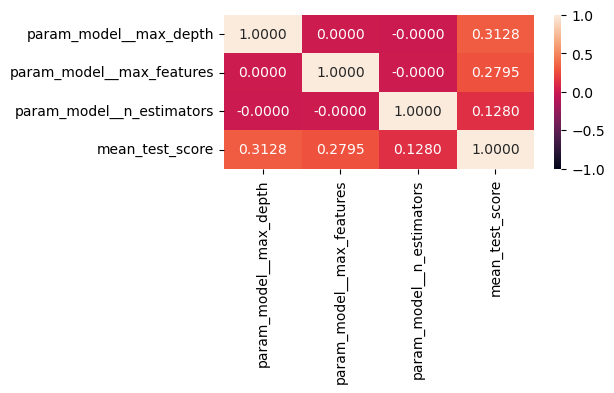

In [24]:
import seaborn as sns
plt.figure(figsize=(5,2))
sns.heatmap(res.corr(), cbar=True, fmt='.4f',vmin=-1, vmax=1, annot=True)
plt.show()

Text(0.5, 1.0, 'Parameters Correlating with validation score')

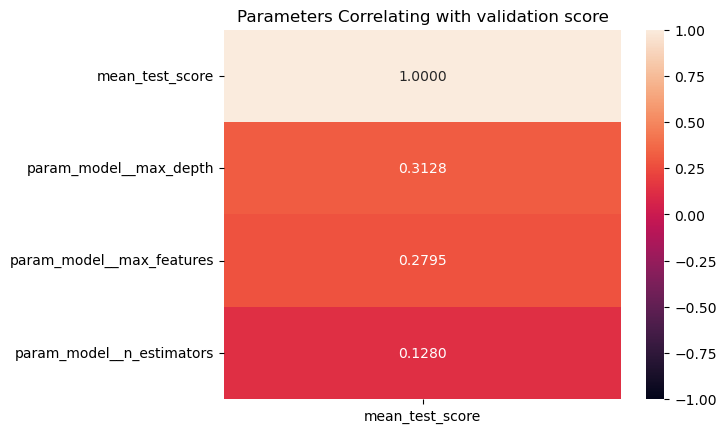

In [25]:
h_map = sns.heatmap(res.corr()[["mean_test_score"]].sort_values(by = "mean_test_score",ascending=False),fmt='.4f',vmin=-1, vmax=1, annot=True)
h_map.set_title("Parameters Correlating with validation score")


In [26]:
model = RandomForestRegressor(max_depth=4, max_features=6, n_estimators=100,oob_score=True) #used above hyperparameters
model.fit(array_train,array_label)

RandomForestRegressor(max_depth=4, max_features=6, oob_score=True)

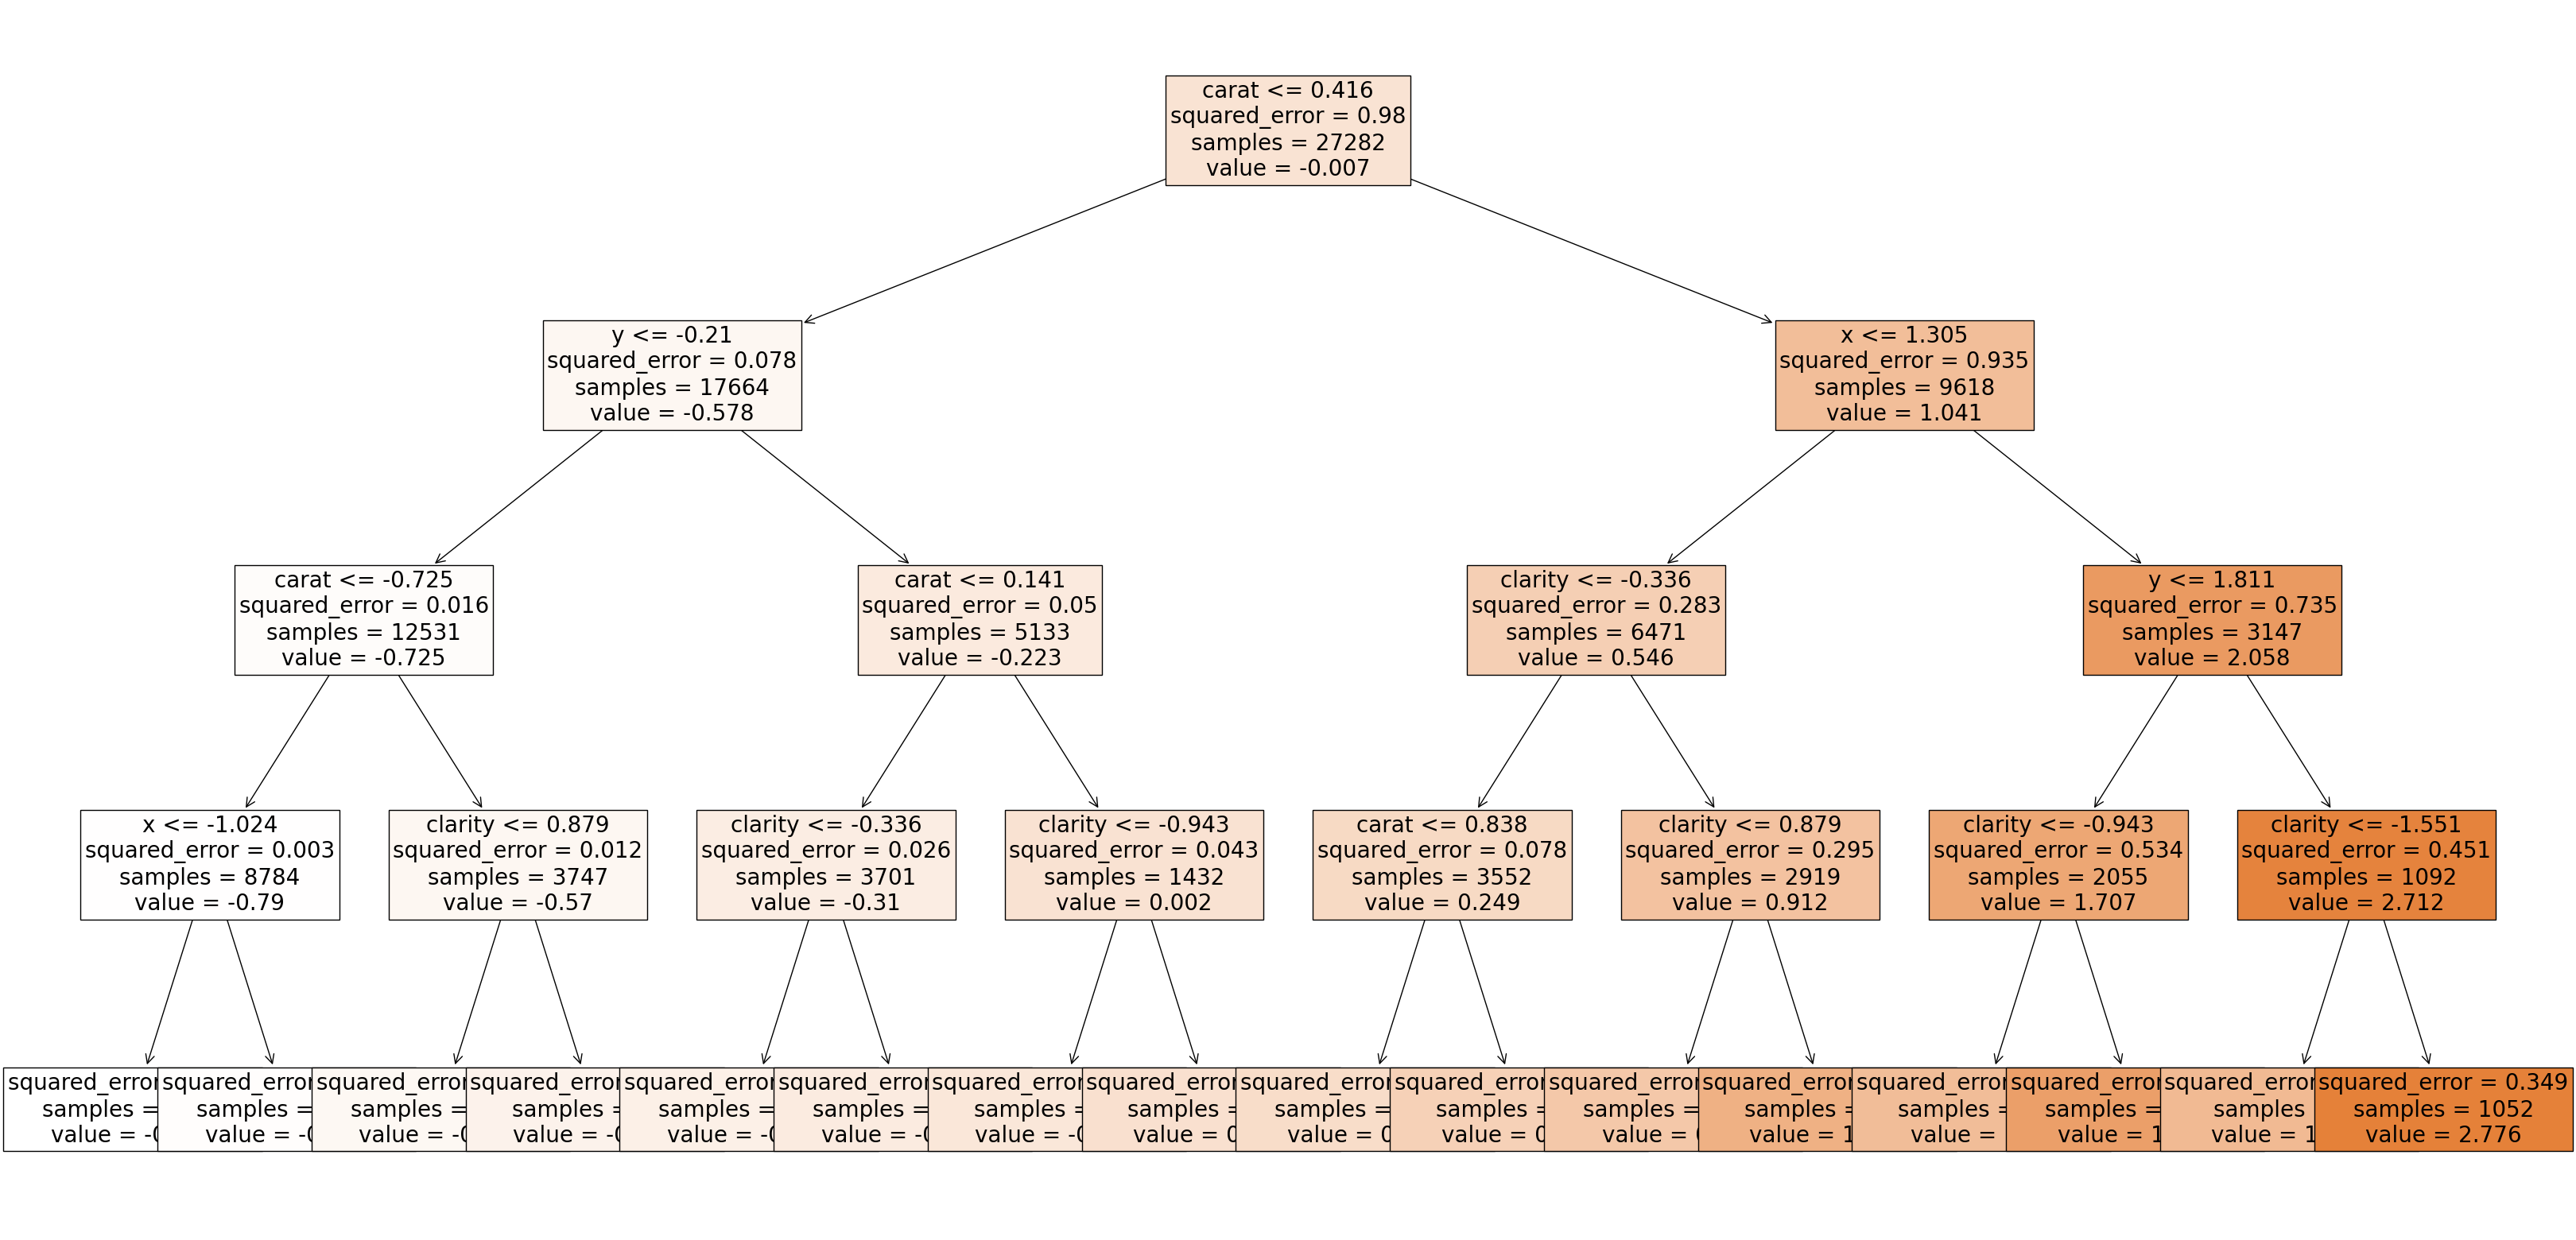

In [27]:
from sklearn import tree

# Plot a tree
plt.figure(figsize=(40,20))
tree.plot_tree(model.estimators_[11], feature_names=df_train_features_ss.columns, filled=True,fontsize=20)
plt.show()

In [28]:
print(model.oob_score_) #4 depth tree oob score
print(model.feature_importances_)
print(df_train_features_ss.columns)

0.9283783394222521
[1.54597876e-04 6.87621481e-03 3.89619859e-02 4.33500727e-01
 3.04407586e-04 0.00000000e+00 1.08239895e-01 4.06234279e-01
 5.72789320e-03]
Index(['cut', 'color', 'clarity', 'carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object')


In [29]:
sort_idx = np.argsort(model.feature_importances_)[::-1]
print("Sorted selected names(in decreasing order): ", df_train_features_ss.columns[sort_idx])

Sorted selected names(in decreasing order):  Index(['carat', 'y', 'x', 'clarity', 'color', 'z', 'depth', 'cut', 'table'], dtype='object')


In [30]:
preds = model.predict(np.array(df_test_features_ss))
r2 = r2_score(np.array(df_test_labels_ss).ravel(), preds)
rmse = mean_squared_error(np.array(df_test_labels_ss).ravel(), preds, squared=False)
print(r2)
print(rmse)

0.929408336752099
0.26549941409334327
